In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
xls      = pd.ExcelFile('CaseStudy.xlsx')
df_tdf   = pd.read_excel(xls,'Tiera Del Fuego data')
df_pazzo = pd.read_excel(xls,"Pazzo's data")

In [3]:
df_tdf.head()

,DC,Date,SKU,Purchase Order Units,Fulfilled Units
0,DC East,2017-10-02,SKU001,10,10
1,DC East,2017-10-09,SKU001,24,24
2,DC East,2017-10-16,SKU001,0,0
3,DC East,2017-10-23,SKU001,0,0
4,DC East,2017-10-30,SKU001,3,3


In [4]:
df_tdf['cut'] = df_tdf['Purchase Order Units'] - df_tdf['Fulfilled Units']

for i in [1]:
    df_tdf['cut_lag_'+str(i)] = df_tdf.groupby(['SKU','DC'])['cut'].shift(i)


df_tdf = df_tdf.fillna(0)




In [5]:
df_tdf.head()

,DC,Date,SKU,Purchase Order Units,Fulfilled Units,cut,cut_lag_1
0,DC East,2017-10-02,SKU001,10,10,0,0.0
1,DC East,2017-10-09,SKU001,24,24,0,0.0
2,DC East,2017-10-16,SKU001,0,0,0,0.0
3,DC East,2017-10-23,SKU001,0,0,0,0.0
4,DC East,2017-10-30,SKU001,3,3,0,0.0


In [6]:
df_pazzo.head()

,SKU,Date,On Hand Inventory,Pageview Out of Stock,Average Price,Change in Pageviews,Consumer Ordered Units,Forecast 1 Week,Forecast 4 Week,Forecast 8 Week
0,SKU001,2017-10-02,519,0.020876,17.913664,0.076624,67,52,47,41
1,SKU001,2017-10-09,241,0.595398,13.520821,0.171255,49,45,42,36
2,SKU001,2017-10-16,559,0.000000,15.839939,0.088271,95,94,89,84
3,SKU001,2017-10-23,424,0.000000,13.128688,0.141562,79,80,79,71
4,SKU001,2017-10-30,488,0.041484,16.277441,-0.164290,49,81,76,78


In [7]:
df_tdf = pd.merge(df_tdf,df_pazzo,on = ['SKU','Date'],how = 'left') #joining pazzo data to tdf on SKU and date level
df_tdf.head()

,DC,Date,SKU,Purchase Order Units,Fulfilled Units,cut,cut_lag_1,On Hand Inventory,Pageview Out of Stock,Average Price,Change in Pageviews,Consumer Ordered Units,Forecast 1 Week,Forecast 4 Week,Forecast 8 Week
0,DC East,2017-10-02,SKU001,10,10,0,0.0,519,0.020876,17.913664,0.076624,67,52,47,41
1,DC East,2017-10-09,SKU001,24,24,0,0.0,241,0.595398,13.520821,0.171255,49,45,42,36
2,DC East,2017-10-16,SKU001,0,0,0,0.0,559,0.000000,15.839939,0.088271,95,94,89,84
3,DC East,2017-10-23,SKU001,0,0,0,0.0,424,0.000000,13.128688,0.141562,79,80,79,71
4,DC East,2017-10-30,SKU001,3,3,0,0.0,488,0.041484,16.277441,-0.164290,49,81,76,78


In [8]:
#df_tdf = df_tdf.drop(df_tdf[df_tdf['SKU'].isin(['SKU033'])].index)

In [9]:
#feature engineering
# lag2 features for the aggregated columns in pazzo data
for i in [2] :
    df_tdf['pageviewlag'+'_'+str(i)]            = df_tdf.groupby(['SKU','DC'])['Pageview Out of Stock'].shift(i)
    df_tdf['AveragePricelag'+'_'+str(i)]        = df_tdf.groupby(['SKU','DC'])['Average Price'].shift(i)
    df_tdf['Change in Pageviewslag'+'_'+str(i)] = df_tdf.groupby(['SKU','DC'])['Change in Pageviews'].shift(i)
    df_tdf['Consumer Ordered Unitslag'+'_'+str(i)] = df_tdf.groupby(['SKU','DC'])['Consumer Ordered Units'].shift(i)
# lag1 and lag2 features for non aggregated columns in the tdf and pazzo data like on hand inventory and Purchase Order Units
for i in [1,2] :
    df_tdf['Purchase Order Unitslag'+'_'+str(i)]   = df_tdf.groupby(['SKU','DC'])['Purchase Order Units'].shift(i)
    df_tdf['On Hand Inventorylag'+'_'+str(i)]      = df_tdf.groupby(['SKU','DC'])['On Hand Inventory'].shift(i)
    
# Difference for Purchase Order Units and On hand inventory    

df_tdf['Purchase Order Unitsdiff']           = df_tdf.groupby(['SKU','DC'])['Purchase Order Unitslag_1'].diff()

df_tdf['Purchase Order Unitsdiff2']           = df_tdf.groupby(['SKU','DC'])['Purchase Order Unitslag_1'].diff(2)

df_tdf['On Hand Inventorydiff']              = df_tdf.groupby(['SKU','DC'])['On Hand Inventorylag_1'].diff()


# exponentially smoothed rolling mean for different alphas
for a in [0.1,0.7,0.9] :
    df_tdf['ewm'+'_'+str(a)] = df_tdf.groupby(['SKU','DC'])['Purchase Order Unitslag_1'].transform(lambda x : x.ewm(alpha=a).mean().values).reset_index(drop=True)
    
    

In [10]:
#df_tdf['Change in Pageviewslag_2'] = np.where(df_tdf['Change in Pageviewslag_2'] < 0,0,1)

In [11]:
df_tdf['SKU_mean'] = df_tdf.groupby(['DC','SKU'])['Purchase Order Units'].transform('mean') # mean purchase order units at SKU DC level 
df_tdf['SKU_std']  = df_tdf.groupby(['DC','SKU'])['Purchase Order Units'].transform('std')  # std purchase order units at SKU DC level
df_tdf['SKU_cov']  = df_tdf['SKU_std']/df_tdf['SKU_mean'] # cov purchase order units at SKU DC level

#adding month features like monthly mean,std and cov at DC SKU level
df_tdf['Month'] = df_tdf['Date'].dt.month

df_tdf_month = df_tdf.groupby(['DC','SKU','Month'],as_index=False)['Purchase Order Units'].sum()

df_tdf_month = df_tdf_month.groupby(['DC','SKU'],as_index = False).agg({'Purchase Order Units' : ['mean','std']})

df_tdf_month.columns = ['_month'.join(i) for i in df_tdf_month.columns.values] #to get the dataframe in the form we want

df_tdf_month = df_tdf_month.rename(columns = {'DC_month' : 'DC','SKU_month' : 'SKU'})

df_tdf = pd.merge(df_tdf,df_tdf_month,on = ['SKU','DC'],how = 'left')

df_tdf['Purchase Order Units_monthcov'] = df_tdf['Purchase Order Units_monthstd']/df_tdf['Purchase Order Units_monthmean']

In [12]:
df_tdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5200 entries, 0 to 5199
Data columns (total 36 columns):
DC                                5200 non-null object
Date                              5200 non-null datetime64[ns]
SKU                               5200 non-null object
Purchase Order Units              5200 non-null int64
Fulfilled Units                   5200 non-null int64
cut                               5200 non-null int64
cut_lag_1                         5200 non-null float64
On Hand Inventory                 5200 non-null int64
Pageview Out of Stock             5200 non-null float64
Average Price                     5200 non-null float64
Change in Pageviews               5200 non-null float64
Consumer Ordered Units            5200 non-null int64
Forecast 1 Week                   5200 non-null int64
Forecast 4 Week                   5200 non-null int64
Forecast 8 Week                   5200 non-null int64
pageviewlag_2                     5000 non-null float64
AverageP

In [13]:
df_tdf.head()

,DC,Date,SKU,Purchase Order Units,Fulfilled Units,cut,cut_lag_1,On Hand Inventory,Pageview Out of Stock,Average Price,...,ewm_0.1,ewm_0.7,ewm_0.9,SKU_mean,SKU_std,SKU_cov,Month,Purchase Order Units_monthmean,Purchase Order Units_monthstd,Purchase Order Units_monthcov
0,DC East,2017-10-02,SKU001,10,10,0,0.0,519,0.020876,17.913664,...,NaN,NaN,NaN,20.519231,25.334229,1.234658,10,88.916667,74.344968,0.83612
1,DC East,2017-10-09,SKU001,24,24,0,0.0,241,0.595398,13.520821,...,10.000000,10.000000,10.000000,20.519231,25.334229,1.234658,10,88.916667,74.344968,0.83612
2,DC East,2017-10-16,SKU001,0,0,0,0.0,559,0.000000,15.839939,...,17.368421,20.769231,22.727273,20.519231,25.334229,1.234658,10,88.916667,74.344968,0.83612
3,DC East,2017-10-23,SKU001,0,0,0,0.0,424,0.000000,13.128688,...,10.959410,5.827338,2.252252,20.519231,25.334229,1.234658,10,88.916667,74.344968,0.83612
4,DC East,2017-10-30,SKU001,3,3,0,0.0,488,0.041484,16.277441,...,7.772608,1.714891,0.225023,20.519231,25.334229,1.234658,10,88.916667,74.344968,0.83612


In [14]:
df_tdf['Purchase Order Units_log'] = df_tdf['Purchase Order Units'].apply(np.log1p)

In [15]:
#train test splitting
df_tdf_train =  df_tdf[df_tdf['Date'].isin(pd.date_range('2017-10-02','2018-05-20'))].reset_index(drop = True)
df_tdf_test  =  df_tdf[df_tdf['Date'].isin(pd.date_range('2018-05-21','2018-09-24'))].reset_index(drop = True)

#creating dummy variable for DC
df_tdf_train = pd.concat([df_tdf_train,pd.get_dummies(df_tdf_train['DC'],drop_first = True)],axis = 1).drop(['DC'],axis = 1)
df_tdf_test = pd.concat([df_tdf_test,pd.get_dummies(df_tdf_test['DC'],drop_first = True)],axis = 1).drop(['DC'],axis = 1)

df_tdf_train = df_tdf_train.dropna()
df_tdf_test = df_tdf_test.dropna()


In [16]:
df_tdf_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1900 entries, 0 to 1899
Data columns (total 37 columns):
Date                              1900 non-null datetime64[ns]
SKU                               1900 non-null object
Purchase Order Units              1900 non-null int64
Fulfilled Units                   1900 non-null int64
cut                               1900 non-null int64
cut_lag_1                         1900 non-null float64
On Hand Inventory                 1900 non-null int64
Pageview Out of Stock             1900 non-null float64
Average Price                     1900 non-null float64
Change in Pageviews               1900 non-null float64
Consumer Ordered Units            1900 non-null int64
Forecast 1 Week                   1900 non-null int64
Forecast 4 Week                   1900 non-null int64
Forecast 8 Week                   1900 non-null int64
pageviewlag_2                     1900 non-null float64
AveragePricelag_2                 1900 non-null float64
Change 

In [17]:
#splitting into X and y
X_train = df_tdf_train.drop(['Date','SKU','Purchase Order Units','Purchase Order Units_log','cut','Month','Fulfilled Units','Pageview Out of Stock','On Hand Inventory','Average Price','Change in Pageviews','Consumer Ordered Units','SKU_cov'],axis = 1)
X_test  = df_tdf_test.drop(['Date','SKU','Purchase Order Units','Purchase Order Units_log','cut','Month','Fulfilled Units','Pageview Out of Stock','On Hand Inventory','Average Price','Change in Pageviews','Consumer Ordered Units','SKU_cov'],axis = 1)
y_train = df_tdf_train['Purchase Order Units']
y_test  = df_tdf_test['Purchase Order Units']



In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 3 to 3299
Data columns (total 24 columns):
cut_lag_1                         3000 non-null float64
Forecast 1 Week                   3000 non-null int64
Forecast 4 Week                   3000 non-null int64
Forecast 8 Week                   3000 non-null int64
pageviewlag_2                     3000 non-null float64
AveragePricelag_2                 3000 non-null float64
Change in Pageviewslag_2          3000 non-null float64
Consumer Ordered Unitslag_2       3000 non-null float64
Purchase Order Unitslag_1         3000 non-null float64
On Hand Inventorylag_1            3000 non-null float64
Purchase Order Unitslag_2         3000 non-null float64
On Hand Inventorylag_2            3000 non-null float64
Purchase Order Unitsdiff          3000 non-null float64
Purchase Order Unitsdiff2         3000 non-null float64
On Hand Inventorydiff             3000 non-null float64
ewm_0.1                           3000 non-null float64
ewm

In [19]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(random_state = 42,max_features = 0.8,max_depth = 6 ,n_estimators = 100)
clf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features=0.8, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [20]:
clf.predict(X_test)

array([ 19.23985321,  19.23985321,  19.23985321, ..., 227.37283422,
       224.52601571, 236.02120502])

In [21]:
clf.score(X_test,y_test)

0.559507548077939

In [22]:
clf.score(X_train,y_train)

0.8103583494181912

In [23]:
df_tdf_test['rf']  = clf.predict(X_test)  #adding predictions to test data
df_tdf_train['rf'] = clf.predict(X_train) #adding predictions to train data

In [24]:
#lasso
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler,StandardScaler,Normalizer,RobustScaler
sc = MinMaxScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)
from sklearn.linear_model import Lasso
lm = Lasso(alpha = 0.5, max_iter =100000)
lm.fit(X_train_sc,y_train)

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=100000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [25]:
df_tdf_test['lm']  = lm.predict(X_test_sc) 
df_tdf_train['lm'] = lm.predict(X_train_sc)

In [26]:
#knn
X_train = X_train[['cut_lag_1', 'Purchase Order Unitsdiff', 'Forecast 4 Week',
       'Forecast 1 Week', 'SKU_mean', 'Purchase Order Units_monthmean',
       'AveragePricelag_2', 'ewm_0.1', 'Forecast 8 Week',
       'Purchase Order Units_monthstd']]
X_test = X_test[['cut_lag_1', 'Purchase Order Unitsdiff', 'Forecast 4 Week',
       'Forecast 1 Week', 'SKU_mean', 'Purchase Order Units_monthmean',
       'AveragePricelag_2', 'ewm_0.1', 'Forecast 8 Week',
       'Purchase Order Units_monthstd']]
from sklearn.preprocessing import MinMaxScaler,StandardScaler,Normalizer,RobustScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors = 14)
knn.fit(X_train_sc,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=14, p=2,
          weights='uniform')

In [27]:
df_tdf_test['knn']  = knn.predict(X_test_sc)
df_tdf_train['knn'] = knn.predict(X_train_sc)

In [28]:
#lightgbm ensemble
#only using the above predictions as features
X_train = df_tdf_train[['rf','lm','knn']]
X_test = df_tdf_test[['rf','lm','knn']]


In [29]:
# custom loss function for lightgbm model
def custom_objective(y_true, y_hat):
    y_pred = y_hat
    y_true = y_true
    residual = (y_true-y_pred).astype("float")
    grad = np.where(residual > 0, -2.0*1.5*residual, -2.0*residual) # giving more weight to an under prediction
    hess = np.where(residual > 0, 2.0*1.5,2.0)
    return grad, hess

def custom_eval(y_true, y_hat):
    y_pred = y_hat
    y_true = y_true
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual > 0, (residual**2)*1.5, residual**2) 
    return "custom error", np.mean(loss), False

In [30]:
import lightgbm as lgb

In [31]:

#Light gbm model
# almost similar features to scikit learn gradient boosting 
gbm = lgb.LGBMRegressor(random_state=42,
                              n_estimators=800,
                             max_depth = 2,
                             learning_rate = 0.01,
                             num_leaves =10,boosting_type = 'gbdt')

gbm.set_params(**{'objective': custom_objective}, metrics = ["mse", 'mae'],)

gbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=custom_eval,
    verbose=False,
)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.01, max_depth=2,
       metrics=['mse', 'mae'], min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=800,
       n_jobs=-1, num_leaves=10,
       objective=<function custom_objective at 0x0000020B1CB98C80>,
       random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [32]:
df_tdf_test['Prediction'] = gbm.predict(X_test)

In [33]:
gbm.score(X_test,y_test)

0.5502969717849453

In [34]:
gbm.score(X_train,y_train)

0.835872467917456

In [35]:
df_tdf_test['Prediction'] = np.where(df_tdf_test['Prediction'] > 0,df_tdf_test['Prediction'],0) #making negative predictions as 0

In [36]:
from sklearn.metrics import r2_score
r2_score(df_tdf_test['Purchase Order Units'].values,df_tdf_test['Prediction'].values)

0.5502969717849453

In [37]:
# from sklearn.metrics import r2_score
# r2_score(df_tdf_train['Purchase Order Units'].values,df_tdf_train['Prediction'].values)

In [38]:
df_tdf_test['cut']           = df_tdf_test['Purchase Order Units'] - df_tdf_test['Fulfilled Units']

#calculating cuts due to prediction
df_tdf_test['Predicted cut'] = np.where(df_tdf_test['Purchase Order Units'] - df_tdf_test['Prediction'] > 0,df_tdf_test['Purchase Order Units'] - df_tdf_test['Prediction'],0)

In [39]:
#reduction in cut as a fraction, multiply by 100 for percentage
(df_tdf_test['cut'].sum() - df_tdf_test['Predicted cut'].sum())/df_tdf_test['cut'].sum()

0.22164179480353086

In [40]:
#increase in inventory as a fraction, multiply by 100 for percentage
(df_tdf_test['Prediction'].sum() - df_tdf_test['Purchase Order Units'].sum())/df_tdf_test['Purchase Order Units'].sum()

0.2941282474584012

In [41]:
df_tdf_test['Predicted cut'].sum()

62840.749696536936

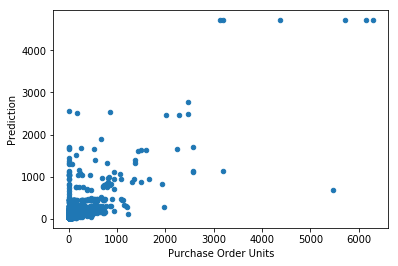

In [42]:
df_tdf_test.plot(kind = 'scatter',x = 'Purchase Order Units',y='Prediction')

In [43]:
df_tdf_test['Prediction'].sum()

306823.5720616649

In [44]:
df_tdf_test['Purchase Order Units'].sum()

237089

Text(0.5,1,'Purchase Order Pattern')

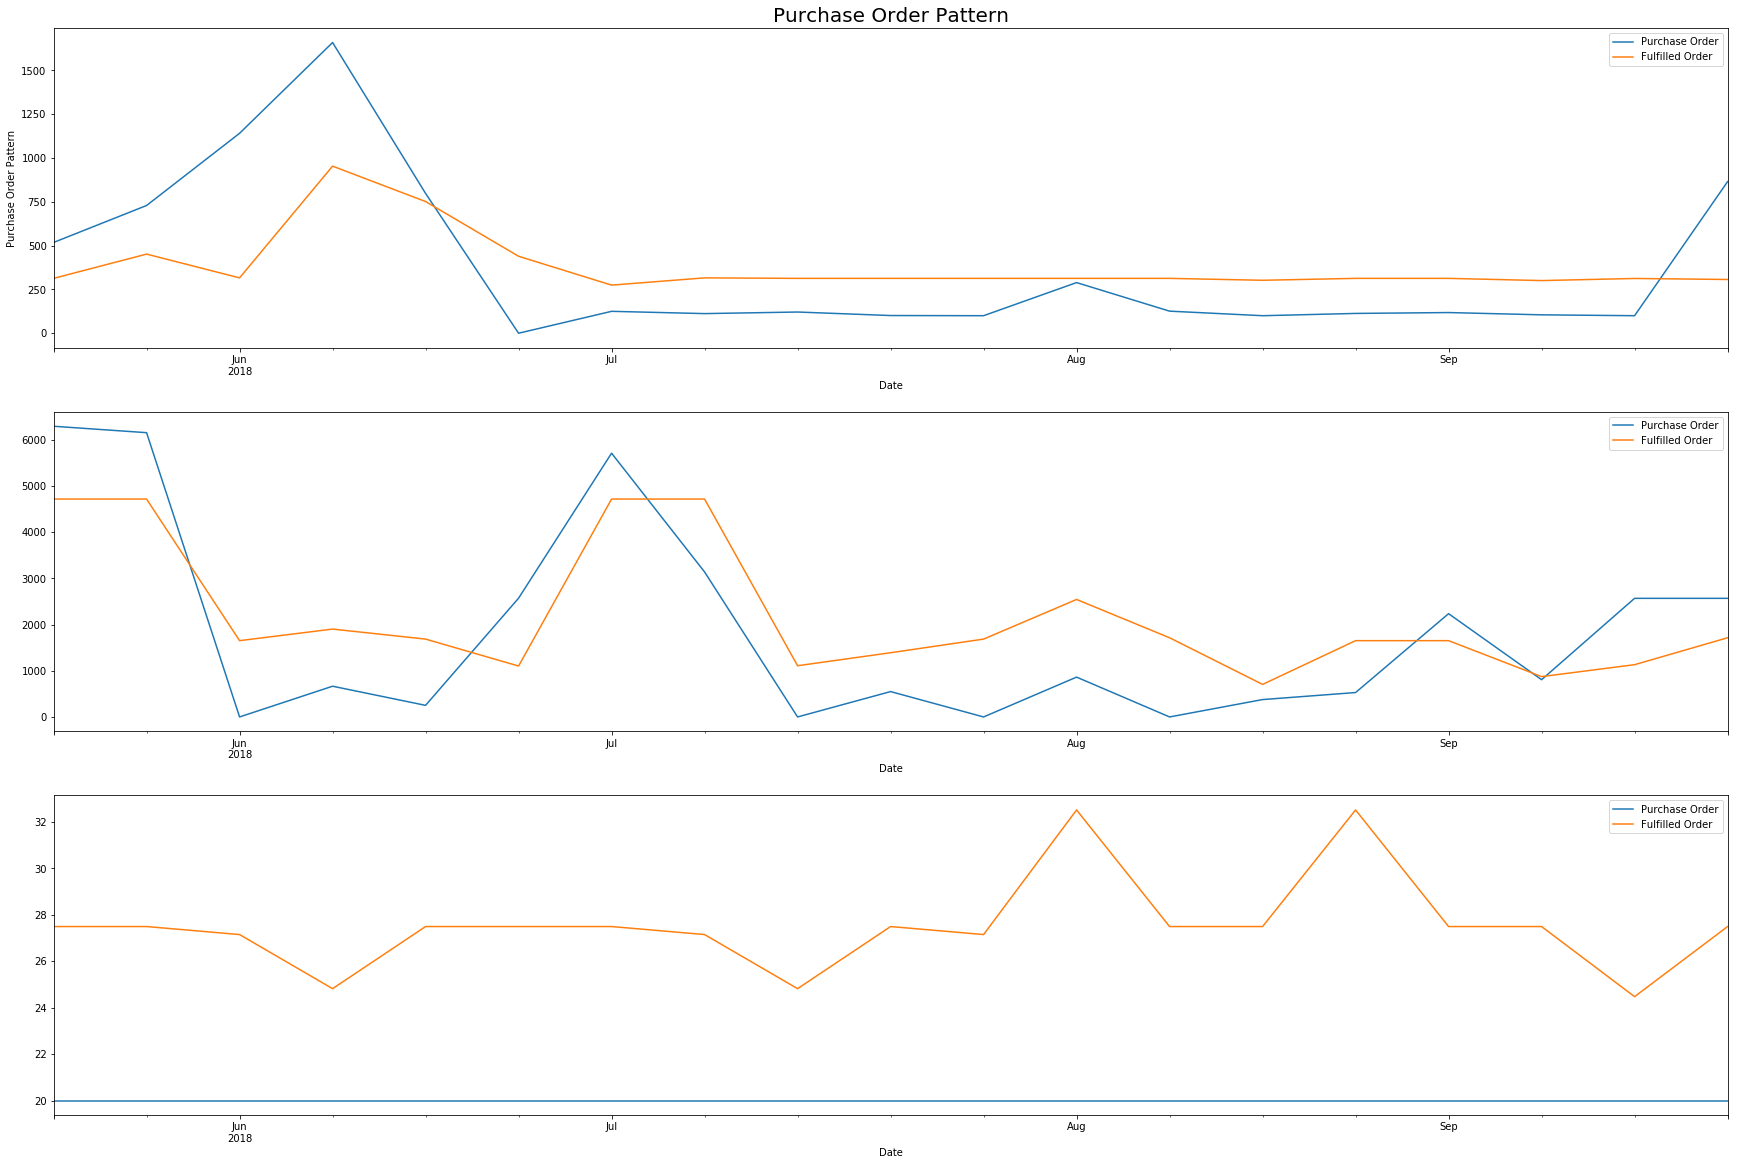

In [45]:
#checking predictions for few SKUs
fig,axes=plt.subplots(3,1,figsize=(30,20))
df_tdf_test[(df_tdf_test['DC West'] == 0) & (df_tdf_test['SKU']=='SKU050')].plot(x='Date',y='Purchase Order Units',label='Purchase Order',ax=axes[0])
df_tdf_test[(df_tdf_test['DC West'] == 0) & (df_tdf_test['SKU']=='SKU050')].plot(x='Date',y='Prediction',label='Fulfilled Order',ax=axes[0])
df_tdf_test[(df_tdf_test['DC West'] == 0) & (df_tdf_test['SKU']=='SKU033')].plot(x='Date',y='Purchase Order Units',label='Purchase Order',ax=axes[1])
df_tdf_test[(df_tdf_test['DC West'] == 0) & (df_tdf_test['SKU']=='SKU033')].plot(x='Date',y='Prediction',label='Fulfilled Order',ax=axes[1])
df_tdf_test[(df_tdf_test['DC West'] == 0) & (df_tdf_test['SKU']=='SKU044')].plot(x='Date',y='Purchase Order Units',label='Purchase Order',ax=axes[2])
df_tdf_test[(df_tdf_test['DC West'] == 0) & (df_tdf_test['SKU']=='SKU044')].plot(x='Date',y='Prediction',label='Fulfilled Order',ax=axes[2])
axes[0].set_ylabel("Purchase Order Pattern")
axes[0].set_title("Purchase Order Pattern",fontsize=20)


In [46]:
#Analyzing prediction and cut at SKU level
sku = df_tdf_test.groupby(['SKU'],as_index = False)[['cut','Predicted cut','Purchase Order Units']].sum().sort_values(by = 'Purchase Order Units',ascending = False).reset_index(drop = True)

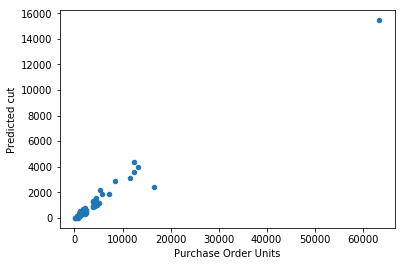

In [47]:
#relationship between predicted cut and Purchase Order Units
sku.plot(kind ='scatter',x = 'Purchase Order Units', y ='Predicted cut')

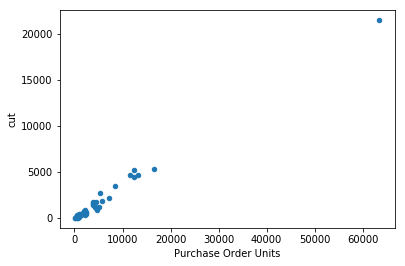

In [48]:
sku.plot(kind ='scatter',x = 'Purchase Order Units', y ='cut')

In [49]:
sku.head()

,SKU,cut,Predicted cut,Purchase Order Units
0,SKU033,21472,15448.758734,63444
1,SKU002,5363,2409.278662,16535
2,SKU019,4669,3952.578985,13144
3,SKU048,5246,4400.468050,12466
4,SKU050,4496,3595.986587,12367


In [50]:
sku['percent'] = (sku['cut'] - sku['Predicted cut'])/sku['cut']*100 #percentage reduction in cuts per SKU

In [51]:
#If prediction is greater than the purchase order units then restrict prediction to the purchase order units as that would be the units fulfilled
df_tdf_test['Prediction'] = np.where(df_tdf_test['Prediction'] > df_tdf_test['Purchase Order Units'],df_tdf_test['Purchase Order Units'],df_tdf_test['Prediction'])

In [52]:
#fulfilling patterns with the predictions
sku = df_tdf_test.groupby(['SKU'],as_index = False)[['Fulfilled Units','Prediction','Purchase Order Units']].sum().sort_values(by = 'Purchase Order Units',ascending = False)

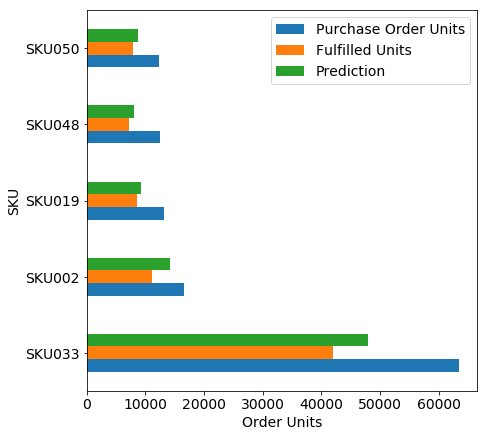

In [53]:
#plotting the purchase order units, the prediced units and the originally fulfilled units by TDF
fig,axes = plt.subplots(figsize= (7,7))
sku.head(5).plot(x = 'SKU', y= ['Purchase Order Units','Fulfilled Units','Prediction'], kind='barh',ax = axes)
plt.xlabel("Order Units",fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("SKU",fontsize = 14)
plt.legend(fontsize =14)
plt.show()